This notebook provides a step-by-step explaination of data preprocessing and modelling processes in investigating the effective machine learning techniques for device categories prediction. 


# Import packages and Dataset
* This section imports the necessaray packages for data preparation, data analysis, and reporting.
* Datasets used for training, testing and experimenting processes are imported and renamed for more efficient analysis.

In [51]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.svm import SVC
from sklearn.utils import shuffle
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction import FeatureHasher
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score, make_scorer, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.semi_supervised import LabelPropagation
from sklearn.model_selection import GridSearchCV
import socket
import struct
from ipaddress import ip_network

In [2]:
swisstools_assets = r"./data/swisstools_assets.csv"
swisstools_asset_types = r"./data/swisstools_asset_types.csv"
swisstools_asset_properties = r"./data/swisstools_asset_properties.csv"
swisstools_asset_relationships = r"./data/swisstools_asset_relationships.csv"
swisstools_asset_relationship_services = r"./data/swisstools_asset_relationship_services.csv"
swisstools_asset_relationship_service_metrics = r"./data/swisstools_asset_relationship_service_metrics.csv"

haarlem_assets = r"./data/haarlem_assets.csv"
haarlem_asset_types = r"./data/haarlem_asset_types.csv"
haarlem_asset_properties = r"./data/haarlem_asset_properties.csv"
haarlem_asset_relationships = r"./data/haarlem_asset_relationships.csv"
haarlem_asset_relationship_services = r"./data/haarlem_asset_relationship_services.csv"
haarlem_asset_relationship_service_metrics = r"./data/haarlem_asset_relationship_service_metrics.csv"

backend_assets = r"./data/backend_asset.csv"
backend_asset_types = r"./data/backend_assettype.csv"
backend_asset_properties = r"./data/backend_assetproperty.csv"
backend_asset_relationships = r"./data/backend_assetrelationship.csv"
backend_asset_relationship_services = r"./data/backend_assetrelationshipservice.csv"
backend_asset_relationship_service_metrics = r"./data/backend_assetrelationshipservicemetric.csv" 

expe_backend_assets = r"./data/expe_backend_asset.csv"
expe_backend_asset_types = r"./data/expe_backend_assettype.csv"
expe_backend_asset_properties = r"./data/expe_backend_assetproperty.csv"
expe_backend_asset_relationships = r"./data/expe_backend_assetrelationship.csv"
expe_backend_asset_relationship_services = r"./data/expe_backend_assetrelationshipservice.csv"
expe_backend_asset_relationship_service_metrics = r"./data/expe_backend_assetrelationshipservicemetric.csv" 

s_assets = pd.DataFrame(pd.read_csv(swisstools_assets))
s_types = pd.DataFrame(pd.read_csv(swisstools_asset_types))
s_properties = pd.DataFrame(pd.read_csv(swisstools_asset_properties))
s_rela = pd.DataFrame(pd.read_csv(swisstools_asset_relationships))
s_services = pd.DataFrame(pd.read_csv(swisstools_asset_relationship_services))
s_metrics = pd.DataFrame(pd.read_csv(swisstools_asset_relationship_service_metrics))

h_assets = pd.DataFrame(pd.read_csv(haarlem_assets))
h_types = pd.DataFrame(pd.read_csv(haarlem_asset_types))
h_properties = pd.DataFrame(pd.read_csv(haarlem_asset_properties))
h_rela = pd.DataFrame(pd.read_csv(haarlem_asset_relationships))
h_services = pd.DataFrame(pd.read_csv(haarlem_asset_relationship_services))
h_metrics = pd.DataFrame(pd.read_csv(haarlem_asset_relationship_service_metrics))

b_assets = pd.DataFrame(pd.read_csv(backend_assets))
b_types = pd.DataFrame(pd.read_csv(backend_asset_types))
b_properties = pd.DataFrame(pd.read_csv(backend_asset_properties))
b_rela = pd.DataFrame(pd.read_csv(backend_asset_relationships))
b_services = pd.DataFrame(pd.read_csv(backend_asset_relationship_services))
b_metrics = pd.DataFrame(pd.read_csv(backend_asset_relationship_service_metrics))

expe_assets = pd.DataFrame(pd.read_csv(expe_backend_assets))
expe_types = pd.DataFrame(pd.read_csv(expe_backend_asset_types))
expe_properties = pd.DataFrame(pd.read_csv(expe_backend_asset_properties))
expe_rela = pd.DataFrame(pd.read_csv(expe_backend_asset_relationships))
expe_services = pd.DataFrame(pd.read_csv(expe_backend_asset_relationship_services))
expe_metrics = pd.DataFrame(pd.read_csv(expe_backend_asset_relationship_service_metrics))

/tmp/ipykernel_1055291/2166465505.py:29: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  s_assets = pd.DataFrame(pd.read_csv(swisstools_assets))
/tmp/ipykernel_1055291/2166465505.py:43: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  b_assets = pd.DataFrame(pd.read_csv(backend_assets))
/tmp/ipykernel_1055291/2166465505.py:50: DtypeWarning: Columns (1,17) have mixed types. Specify dtype option on import or set low_memory=False.
  expe_assets = pd.DataFrame(pd.read_csv(expe_backend_assets))


# Data Merging and Filtering


A crucial step involved merging the relevant information stored separately across multiple tables to create a combined dataset for further analysis. This process was executed by utilizing primary and foreign keys identified in the database schema, which defines the structure and the assets’ relationships between tables.

The selected variables from the Asset and Service tables are highly relevant for training the machine learning model with provide important information.
* IP addresses and VLAN ids indicate the location of devices in the network, as devices with similar types often correlate and are grouped in similar IP addresses or VLAN ids. \
ipaddress = (a x 256^3) + (b x 256^2) + (c x 256^1)

* The protocol used by an asset reflects how it communicates and reveals communication patterns connected to each type of asset. This feature is encoded as binary variables using OneHotEncoder; each protocol is represented with a value of 1 if the protocol is used and 0 otherwise. 
* The bytes and count variables explain the volume of data and the rates of transferring packets, relatively. These features are processed by aggregating all bytes sent or received by each asset in all relationships.


## Swiss Dataset

In [3]:
original_row_count = len(s_assets)

s_asset_merged = s_assets.merge(
    s_types[['id', 'category', 'name', 'vendor']],
    left_on='asset_type_id',
    right_on='id',
    how='left'  # keep all rows from asset_df, even if no matching type
)
s_asset_merged = s_asset_merged.rename(columns={
    'id_x': 'asset_id',         # asset ID
    'id_y': 'type_id',    # the same as asset_type_id
    'name_y': 'asset_type_name' # name of asset_type_id
})
s_rel_service_merged  = s_rela.merge(
    s_services[['relationship_id', 'protocol', 'bytes', 'count']],
    left_on='id',
    right_on='relationship_id',
    how='right'
)

s_bytes_sent_df = (s_rel_service_merged.groupby('source_asset_id')['bytes']
    .sum().reset_index().rename(columns={'source_asset_id': 'asset_id', 'bytes': 'total_bytes_sent'}))
s_bytes_recv_df = (s_rel_service_merged.groupby('target_asset_id')['bytes']
    .sum().reset_index().rename(columns={'target_asset_id': 'asset_id', 'bytes': 'total_bytes_received'}))
s_count_sent_df = (s_rel_service_merged.groupby('source_asset_id')['count']
    .sum().reset_index().rename(columns={'source_asset_id': 'asset_id', 'count': 'total_count_sent'}))
s_count_recv_df = (s_rel_service_merged.groupby('target_asset_id')['count']
    .sum().reset_index().rename(columns={'target_asset_id': 'asset_id', 'count': 'total_count_received'}))
s_all_protocols = pd.concat([
    s_rel_service_merged[['source_asset_id', 'protocol']].rename(columns={'source_asset_id': 'asset_id'}),
    s_rel_service_merged[['target_asset_id', 'protocol']].rename(columns={'target_asset_id': 'asset_id'})
])
s_protocols_df = (
    s_all_protocols.groupby('asset_id')['protocol']
    .apply(lambda x: ','.join(x.dropna().unique()))
    .reset_index()
    .rename(columns={'protocol': 'protocols_used'})
)

s_final_df = (
    s_asset_merged
    .merge(s_bytes_sent_df, on='asset_id', how='left')
    .merge(s_bytes_recv_df, on='asset_id', how='left')
    .merge(s_count_sent_df, on='asset_id', how='left')
    .merge(s_count_recv_df, on='asset_id', how='left')
    .merge(s_protocols_df, on='asset_id', how='left')
    .fillna({
        'total_bytes_sent': 0,
        'total_bytes_received': 0,
        'total_count_sent': 0,
        'total_count_received': 0,
        'protocols_used': ''
    })
)

protocol_dummies = s_final_df['protocols_used'].str.get_dummies(sep=',')
s_final_df = s_final_df.join(protocol_dummies)
s_final_df = s_final_df[[
    'ipaddress', 'vlan_ids', 'category',
    'total_bytes_sent', 'total_bytes_received',
    'total_count_sent', 'total_count_received', 
    *[f'{col}' for col in protocol_dummies.columns]  
]]

display(s_final_df.head())
s_final_df_filtered = s_final_df[s_final_df['category'].notna()]

,ipaddress,vlan_ids,category,total_bytes_sent,total_bytes_received,total_count_sent,total_count_received,SNMP,TCP,UDP
0,17.253.122.200,{45},NaN,0.0,174480.0,0.0,1041.0,0,1,0
1,59.95.128.68,{1001},NaN,234.0,0.0,3.0,0.0,0,1,0
2,192.168.103.21/24,{2102},Network,0.0,160677332.0,0.0,116689.0,0,1,0
3,183.160.194.143,{1001},NaN,64.0,0.0,1.0,0.0,0,1,0
4,27.25.152.221,{1001},Network,0.0,0.0,0.0,0.0,0,0,0


In [4]:
print(len(s_final_df_filtered['category'].unique()))
print(s_final_df_filtered['category'].unique())

print(f"Number of rows in asset_df before merging: {original_row_count}")
print(f"Number of rows in final_df before filtering: {len(s_final_df)}")
print(f"Number of rows usable for ML (with valid category): {len(s_final_df_filtered)}")

display(s_final_df_filtered[s_final_df_filtered['category']=='Network']) #68385/69151

display(s_final_df_filtered.head())

5
['Network' 'Other' 'IT' 'OT' 'IoT']
Number of rows in asset_df before merging: 229033
Number of rows in final_df before filtering: 229033
Number of rows usable for ML (with valid category): 69151


,ipaddress,vlan_ids,category,total_bytes_sent,total_bytes_received,total_count_sent,total_count_received,SNMP,TCP,UDP
2,192.168.103.21/24,{2102},Network,0.0,160677332.0,0.0,116689.0,0,1,0
4,27.25.152.221,{1001},Network,0.0,0.0,0.0,0.0,0,0,0
5,52.123.242.153,{1001},Network,0.0,64.0,0.0,1.0,0,1,0
6,47.97.33.235,{120},Network,0.0,0.0,0.0,0.0,0,0,0
7,40.86.155.170,{1001},Network,0.0,78.0,0.0,1.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
229015,17.248.236.128,{1007},Network,147583.0,51305.0,455.0,254.0,0,1,0
229019,95.100.252.106,{1007},Network,3557383.0,154089.0,4137.0,357.0,0,1,0
229020,185.242.226.54,{1001},Network,18304.0,0.0,286.0,0.0,0,1,0
229022,104.16.41.28,{45},Network,116966.0,34382.0,202.0,172.0,0,1,0


,ipaddress,vlan_ids,category,total_bytes_sent,total_bytes_received,total_count_sent,total_count_received,SNMP,TCP,UDP
2,192.168.103.21/24,{2102},Network,0.0,160677332.0,0.0,116689.0,0,1,0
4,27.25.152.221,{1001},Network,0.0,0.0,0.0,0.0,0,0,0
5,52.123.242.153,{1001},Network,0.0,64.0,0.0,1.0,0,1,0
6,47.97.33.235,{120},Network,0.0,0.0,0.0,0.0,0,0,0
7,40.86.155.170,{1001},Network,0.0,78.0,0.0,1.0,0,1,0


## Backend Dataset

In [5]:
original_row_count = len(b_assets)

b_asset_merged = b_assets.merge(
    b_types[['id', 'category', 'name', 'vendor']],
    left_on='asset_type_id',
    right_on='id',
    how='left'  # keep all rows from asset_df, even if no matching type
)
b_asset_merged = b_asset_merged.rename(columns={
    'id_x': 'asset_id',         # asset ID
    'id_y': 'type_id',    # the same as asset_type_id
    'name_y': 'asset_type_name' # name of asset_type_id
})
b_rel_service_merged  = b_rela.merge(
    b_services[['relationship_id', 'protocol', 'bytes', 'count']],
    left_on='id',
    right_on='relationship_id',
    how='right'
)

b_bytes_sent_df = (b_rel_service_merged.groupby('source_asset_id')['bytes']
    .sum().reset_index().rename(columns={'source_asset_id': 'asset_id', 'bytes': 'total_bytes_sent'}))
b_bytes_recv_df = (b_rel_service_merged.groupby('target_asset_id')['bytes']
    .sum().reset_index().rename(columns={'target_asset_id': 'asset_id', 'bytes': 'total_bytes_received'}))
b_count_sent_df = (b_rel_service_merged.groupby('source_asset_id')['count']
    .sum().reset_index().rename(columns={'source_asset_id': 'asset_id', 'count': 'total_count_sent'}))
b_count_recv_df = (b_rel_service_merged.groupby('target_asset_id')['count']
    .sum().reset_index().rename(columns={'target_asset_id': 'asset_id', 'count': 'total_count_received'}))
b_all_protocols = pd.concat([
    b_rel_service_merged[['source_asset_id', 'protocol']].rename(columns={'source_asset_id': 'asset_id'}),
    b_rel_service_merged[['target_asset_id', 'protocol']].rename(columns={'target_asset_id': 'asset_id'})
])
b_protocols_df = (
    b_all_protocols.groupby('asset_id')['protocol']
    .apply(lambda x: ','.join(x.dropna().unique()))
    .reset_index()
    .rename(columns={'protocol': 'protocols_used'})
)

b_final_df = (
    b_asset_merged
    .merge(b_bytes_sent_df, on='asset_id', how='left')
    .merge(b_bytes_recv_df, on='asset_id', how='left')
    .merge(b_count_sent_df, on='asset_id', how='left')
    .merge(b_count_recv_df, on='asset_id', how='left')
    .merge(b_protocols_df, on='asset_id', how='left')
    .fillna({
        'total_bytes_sent': 0,
        'total_bytes_received': 0,
        'total_count_sent': 0,
        'total_count_received': 0,
        'protocols_used': ''
    })
)

protocol_dummies = b_final_df['protocols_used'].str.get_dummies(sep=',')
b_final_df = b_final_df.join(protocol_dummies)
b_final_df = b_final_df[[
    'ipaddress', 'vlan_ids', 'category',
    'total_bytes_sent', 'total_bytes_received',
    'total_count_sent', 'total_count_received', 
    *[f'{col}' for col in protocol_dummies.columns]  
]]

display(b_final_df.head())
b_final_df_filtered = b_final_df[b_final_df['category'].notna()]

,ipaddress,vlan_ids,category,total_bytes_sent,total_bytes_received,total_count_sent,total_count_received,SNMP,TCP,UDP
0,192.168.102.11/24,{2102},Other,25447457.0,78700306.0,63298.0,83337.0,0,1,1
1,192.168.45.15/24,{2102},Network,0.0,29820.0,0.0,426.0,0,1,0
2,192.168.101.138/24,{120},Network,0.0,0.0,0.0,0.0,0,0,0
3,192.168.0.139,{2101},Network,0.0,2030.0,0.0,29.0,0,1,0
4,192.168.103.136/24,{120},Network,29788.0,171664.0,98.0,2292.0,0,1,0


In [6]:
print(len(b_final_df_filtered['category'].unique()))
print(b_final_df_filtered['category'].unique())

print(f"Number of rows in asset_df before merging: {original_row_count}")
print(f"Number of rows in final_df before filtering: {len(b_final_df)}")
print(f"Number of rows usable for ML (with valid category): {len(b_final_df_filtered)}")

display(b_final_df_filtered[b_final_df_filtered['category']=='Network']) #68562/119125

display(b_final_df_filtered.head())

5
['Other' 'Network' 'OT' 'IT' 'IoT']
Number of rows in asset_df before merging: 119125
Number of rows in final_df before filtering: 119125
Number of rows usable for ML (with valid category): 68562


,ipaddress,vlan_ids,category,total_bytes_sent,total_bytes_received,total_count_sent,total_count_received,SNMP,TCP,UDP
1,192.168.45.15/24,{2102},Network,0.0,29820.0,0.0,426.0,0,1,0
2,192.168.101.138/24,{120},Network,0.0,0.0,0.0,0.0,0,0,0
3,192.168.0.139,{2101},Network,0.0,2030.0,0.0,29.0,0,1,0
4,192.168.103.136/24,{120},Network,29788.0,171664.0,98.0,2292.0,0,1,0
7,192.168.104.57,{2101},Network,206537.0,192378.0,1092.0,1001.0,0,1,1
...,...,...,...,...,...,...,...,...,...,...
119118,192.168.1.203,{2101},Network,0.0,70.0,0.0,1.0,0,1,0
119121,10.61.242.238,{2102},Network,0.0,1580.0,0.0,10.0,0,0,1
119122,192.168.1.28,{45},Network,0.0,3150.0,0.0,35.0,0,0,1
119123,192.168.36.17,{1001},Network,0.0,70.0,0.0,1.0,0,1,0


,ipaddress,vlan_ids,category,total_bytes_sent,total_bytes_received,total_count_sent,total_count_received,SNMP,TCP,UDP
0,192.168.102.11/24,{2102},Other,25447457.0,78700306.0,63298.0,83337.0,0,1,1
1,192.168.45.15/24,{2102},Network,0.0,29820.0,0.0,426.0,0,1,0
2,192.168.101.138/24,{120},Network,0.0,0.0,0.0,0.0,0,0,0
3,192.168.0.139,{2101},Network,0.0,2030.0,0.0,29.0,0,1,0
4,192.168.103.136/24,{120},Network,29788.0,171664.0,98.0,2292.0,0,1,0


# MODELS


 * For both the Swiss and Backend datasets, the Network category dominates the distribution with approximately 99% of all observations, leaving only around 1% for all other categories combined, including IT, IoT, OT, and other. In order to mitigate this imbalance, stratified splitting was utilized for training and testing sets. This approach ensured that both training and testing sets maintain the same distribution of classes as observed in the original dataset. 
 * The hyperparameter utilized for this purpose was stratify=y and throughout all models, a ratio of 80-20 training and testing sets were utilized, which was implemented using the hyperparameter test_size=0.2 within the code:
 \
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


Three Machine Learning models are used:
* Random Forest is a machine-learning method that builds a large number of Decision Trees to make predictions during the training process. Each individual tree has independent and identically distributed samples as inputs for the decision trees to split data based on the features to predict.
* Naive Bayes is a machine-learning method that assumes all features are independent of each other and uses probabilities of each feature of a class to predict the most accurate class for new data. It calculates the probability of each category that the data point belongs to and selects the one with the highest probability given the features.
* XGBoost, standing for extreme gradient boosting, is also a tree-based model; however, unlike Random Forests, which builds trees independently and averages their results, XGBoost builds trees sequentially as each new tree corrects the errors made by previous ones.

## Functions

In [7]:
def extract_subnet_prefix(ip):
    try:
        ip_no_mask = ip.split('/')[0]
        octets = ip_no_mask.split('.')
        return '.'.join(octets[:3])
    except Exception:
        return None

def get_prefix(ip, octet_count):
    try:
        ip_no_mask = ip.split('/')[0]
        octets = ip_no_mask.split('.')
        return '.'.join(octets[:octet_count])
    except:
        return None
    
def ip_to_int(ip):
    ip_address = ip.split('/')[0]
    return struct.unpack("!I", socket.inet_aton(ip_address))[0]

def mac_to_int(mac):
    return int(mac.replace(":", ""), 16)

def mac_to_int(mac):
    if isinstance(mac, str):  
        return int(mac.replace(":", ""), 16)
    else:
        return None 
    
def clean_vlan_id(vlan):
    if isinstance(vlan, str) and vlan.strip('{}'):
        return int(vlan.strip('{}'))
    else:
        return 0  # Or choose a default value like 0


## Non-Handling Data Imbalance

In [8]:
s_ml_df = s_final_df_filtered.copy()    

s_ml_df['ipaddress'] = s_ml_df['ipaddress'].apply(extract_subnet_prefix).apply(ip_to_int)
s_ml_df['vlan_ids'] = s_ml_df['vlan_ids'].apply(clean_vlan_id)

b_ml_df = b_final_df_filtered.copy()    

b_ml_df['ipaddress'] = b_ml_df['ipaddress'].apply(extract_subnet_prefix).apply(ip_to_int)
b_ml_df['vlan_ids'] = b_ml_df['vlan_ids'].apply(clean_vlan_id)

### Random Forest

In [9]:
# SWISS DATASET
X = s_ml_df.drop(columns=['category'])  
y = s_ml_df['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train_encoded)
y_pred_rf = rf_model.predict(X_test)

class_mapping = label_encoder.classes_

for idx, label in enumerate(class_mapping):
    print(f"Class {idx}: {label}")
    
print("Swiss Dataset: No handling class imbalance Random Forest Classification Report:")
print(classification_report(y_test_encoded, y_pred_rf))

accuracy = accuracy_score(y_test_encoded, y_pred_rf)
print(f"Accuracy: {accuracy * 100:.2f}%")

Class 0: IT
Class 1: IoT
Class 2: Network
Class 3: OT
Class 4: Other
Swiss Dataset: No handling class imbalance Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.61      0.64        66
           1       0.95      0.72      0.82        25
           2       1.00      1.00      1.00     13676
           3       1.00      0.57      0.73         7
           4       0.67      0.75      0.71        57

    accuracy                           1.00     13831
   macro avg       0.86      0.73      0.78     13831
weighted avg       1.00      1.00      1.00     13831

Accuracy: 99.55%


In [10]:
# BACKEND DATASET
X = b_ml_df.drop(columns=['category'])  
y = b_ml_df['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train_encoded)
y_pred_rf = rf_model.predict(X_test)

class_mapping = label_encoder.classes_

for idx, label in enumerate(class_mapping):
    print(f"Class {idx}: {label}")
    
print("Backend Dataset: No handling class imbalance Random Forest Classification Report:")
print(classification_report(y_test_encoded, y_pred_rf))

accuracy = accuracy_score(y_test_encoded, y_pred_rf)
print(f"Accuracy: {accuracy * 100:.2f}%")

Class 0: IT
Class 1: IoT
Class 2: Network
Class 3: OT
Class 4: Other
Backend Dataset: No handling class imbalance Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.78      0.75        59
           1       0.75      0.50      0.60         6
           2       1.00      1.00      1.00     13596
           3       0.92      1.00      0.96        11
           4       0.76      0.54      0.63        41

    accuracy                           1.00     13713
   macro avg       0.83      0.76      0.79     13713
weighted avg       1.00      1.00      1.00     13713

Accuracy: 99.70%


### Naive Bayes

In [11]:
# SWISS DATASET

X = s_ml_df.drop(columns=['category'])  
y = s_ml_df['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_clean = X_train.dropna()
X_test_clean = X_test.dropna()

y_train_clean = y_train.loc[X_train_clean.index]
y_test_clean = y_test.loc[X_test_clean.index]

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_clean)
y_test_encoded = label_encoder.transform(y_test_clean)

nb = GaussianNB()

nb.fit(X_train_clean, y_train_encoded)

y_pred_gnb = nb.predict(X_test_clean)

class_mapping = label_encoder.classes_

for idx, label in enumerate(class_mapping):
    print(f"Class {idx}: {label}")
    
print("Swiss Dataset: No handling class imbalance Gaussian Naive Bayes Classification Report:")
print(classification_report(y_test_encoded, y_pred_gnb))

accuracy = accuracy_score(y_test_encoded, y_pred_gnb)
print(f"Accuracy: {accuracy * 100:.2f}%")

Class 0: IT
Class 1: IoT
Class 2: Network
Class 3: OT
Class 4: Other
Swiss Dataset: No handling class imbalance Gaussian Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.09      0.16        66
           1       0.00      0.00      0.00        25
           2       1.00      0.72      0.84     13676
           3       0.03      1.00      0.06         7
           4       0.01      0.53      0.02        57

    accuracy                           0.72     13831
   macro avg       0.32      0.47      0.22     13831
weighted avg       0.99      0.72      0.83     13831

Accuracy: 71.86%


/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [12]:
# BACKEND DATASET

X = b_ml_df.drop(columns=['category'])  
y = b_ml_df['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_clean = X_train.dropna()
X_test_clean = X_test.dropna()

y_train_clean = y_train.loc[X_train_clean.index]
y_test_clean = y_test.loc[X_test_clean.index]

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_clean)
y_test_encoded = label_encoder.transform(y_test_clean)

nb = GaussianNB()

nb.fit(X_train_clean, y_train_encoded)
y_pred_gnb = nb.predict(X_test_clean)

class_mapping = label_encoder.classes_

for idx, label in enumerate(class_mapping):
    print(f"Class {idx}: {label}")
    
print("Backend Dataset: No handling class imbalance Gaussian Naive Bayes Classification Report:")
print(classification_report(y_test_encoded, y_pred_gnb))

accuracy = accuracy_score(y_test_encoded, y_pred_gnb)
print(f"Accuracy: {accuracy * 100:.2f}%")

Class 0: IT
Class 1: IoT
Class 2: Network
Class 3: OT
Class 4: Other
Backend Dataset: No handling class imbalance Gaussian Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.17      0.23        59
           1       0.00      0.00      0.00         6
           2       1.00      0.99      0.99     13596
           3       0.06      1.00      0.11        11
           4       0.04      0.02      0.03        41

    accuracy                           0.98     13713
   macro avg       0.29      0.44      0.27     13713
weighted avg       0.99      0.98      0.99     13713

Accuracy: 98.28%


/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### XGBoost

In [13]:
# SWISS DATASET

X = s_ml_df.drop(columns=['category'])  
y = s_ml_df['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

xgb_model.fit(X_train, y_train_encoded)
y_pred_xgb = xgb_model.predict(X_test)

class_mapping = label_encoder.classes_

for idx, label in enumerate(class_mapping):
    print(f"Class {idx}: {label}")
    
print("Swiss Dataset: No handling class imbalance XGBoost Classification Report:")
print(classification_report(y_test_encoded, y_pred_xgb))

accuracy = accuracy_score(y_test_encoded, y_pred_xgb)
print(f"Accuracy: {accuracy * 100:.2f}%")

/opt/conda/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:25:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Class 0: IT
Class 1: IoT
Class 2: Network
Class 3: OT
Class 4: Other
Swiss Dataset: No handling class imbalance XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.64      0.62        66
           1       1.00      0.76      0.86        25
           2       1.00      1.00      1.00     13676
           3       0.67      0.57      0.62         7
           4       0.64      0.68      0.66        57

    accuracy                           1.00     13831
   macro avg       0.78      0.73      0.75     13831
weighted avg       1.00      1.00      1.00     13831

Accuracy: 99.51%


In [14]:
# BACKEND DATASET

X = b_ml_df.drop(columns=['category'])  
y = b_ml_df['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

xgb_model.fit(X_train, y_train_encoded)
y_pred_xgb = xgb_model.predict(X_test)

class_mapping = label_encoder.classes_

for idx, label in enumerate(class_mapping):
    print(f"Class {idx}: {label}")
    
print("Swiss Dataset: No handling class imbalance XGBoost Classification Report:")
print(classification_report(y_test_encoded, y_pred_xgb))

accuracy = accuracy_score(y_test_encoded, y_pred_xgb)
print(f"Accuracy: {accuracy * 100:.2f}%")

/opt/conda/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:25:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Class 0: IT
Class 1: IoT
Class 2: Network
Class 3: OT
Class 4: Other
Swiss Dataset: No handling class imbalance XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.75      0.73        59
           1       0.83      0.83      0.83         6
           2       1.00      1.00      1.00     13596
           3       1.00      0.91      0.95        11
           4       0.71      0.54      0.61        41

    accuracy                           1.00     13713
   macro avg       0.85      0.80      0.82     13713
weighted avg       1.00      1.00      1.00     13713

Accuracy: 99.69%


## Class Weighting
This approach applies a penalty on the model for incorrect predictions based on the distribution of each category in the data. This means that categories with higher weights, such as Network and IT, would endure a more severe penalty for misclassification, which subsequently teaches the model to prioritize correctly predicting the less frequent classes. 

In [15]:
s_ml_df = s_final_df_filtered.copy()    

s_ml_df['ipaddress'] = s_ml_df['ipaddress'].apply(extract_subnet_prefix).apply(ip_to_int)
s_ml_df['vlan_ids'] = s_ml_df['vlan_ids'].apply(clean_vlan_id)

display(s_ml_df)
print(len(s_ml_df['ipaddress'].unique()))

b_ml_df = b_final_df_filtered.copy()    

b_ml_df['ipaddress'] = b_ml_df['ipaddress'].apply(extract_subnet_prefix).apply(ip_to_int)
b_ml_df['vlan_ids'] = b_ml_df['vlan_ids'].apply(clean_vlan_id)

display(b_ml_df)
print(len(b_ml_df['ipaddress'].unique()))

,ipaddress,vlan_ids,category,total_bytes_sent,total_bytes_received,total_count_sent,total_count_received,SNMP,TCP,UDP
2,3232235623,2102,Network,0.0,160677332.0,0.0,116689.0,0,1,0
4,454623384,1001,Network,0.0,0.0,0.0,0.0,0,0,0
5,880476402,1001,Network,0.0,64.0,0.0,1.0,0,1,0
6,794886177,120,Network,0.0,0.0,0.0,0.0,0,0,0
7,676724891,1001,Network,0.0,78.0,0.0,1.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
229015,301465836,1007,Network,147583.0,51305.0,455.0,254.0,0,1,0
229019,1600389372,1007,Network,3557383.0,154089.0,4137.0,357.0,0,1,0
229020,3119644898,1001,Network,18304.0,0.0,286.0,0.0,0,1,0
229022,1745879081,45,Network,116966.0,34382.0,202.0,172.0,0,1,0


30807


,ipaddress,vlan_ids,category,total_bytes_sent,total_bytes_received,total_count_sent,total_count_received,SNMP,TCP,UDP
0,3232235622,2102,Other,25447457.0,78700306.0,63298.0,83337.0,0,1,1
1,3232235565,2102,Network,0.0,29820.0,0.0,426.0,0,1,0
2,3232235621,120,Network,0.0,0.0,0.0,0.0,0,0,0
3,3232235520,2101,Network,0.0,2030.0,0.0,29.0,0,1,0
4,3232235623,120,Network,29788.0,171664.0,98.0,2292.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
119120,3232235623,2103,OT,122329.0,9304.0,423.0,41.0,0,1,1
119121,171770098,2102,Network,0.0,1580.0,0.0,10.0,0,0,1
119122,3232235521,45,Network,0.0,3150.0,0.0,35.0,0,0,1
119123,3232235556,1001,Network,0.0,70.0,0.0,1.0,0,1,0


30701


### Random Forest

In [16]:
# SWISS DATASET
X = s_ml_df.drop(columns=['category'])  
y = s_ml_df['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train_encoded)
y_pred_rf = rf_model.predict(X_test)

class_mapping = label_encoder.classes_

for idx, label in enumerate(class_mapping):
    print(f"Class {idx}: {label}")
    
print("Swiss Dataset: Class Weighting Random Forest Classification Report:")
print(classification_report(y_test_encoded, y_pred_rf))

accuracy = accuracy_score(y_test_encoded, y_pred_rf)
print(f"Accuracy: {accuracy * 100:.2f}%")

# print("Training set class distribution:")
# print(y_train.value_counts(normalize=True))
# print(y_train.value_counts(normalize=False))

# print("\nTest set class distribution:") 
# print(y_test.value_counts(normalize=True))
# print(y_test.value_counts(normalize=False)

Class 0: IT
Class 1: IoT
Class 2: Network
Class 3: OT
Class 4: Other
Swiss Dataset: Class Weighting Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.73      0.70        73
           1       1.00      0.81      0.90        16
           2       1.00      1.00      1.00     13678
           3       0.71      0.71      0.71         7
           4       0.76      0.65      0.70        57

    accuracy                           1.00     13831
   macro avg       0.83      0.78      0.80     13831
weighted avg       1.00      1.00      1.00     13831

Accuracy: 99.58%


In [17]:
# BACKEND DATASET
X = b_ml_df.drop(columns=['category'])  
y = b_ml_df['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train_encoded)
y_pred_rf = rf_model.predict(X_test)

class_mapping = label_encoder.classes_

for idx, label in enumerate(class_mapping):
    print(f"Class {idx}: {label}")
    
print("Backend Dataset: Class Weighting Random Forest Classification Report:")
print(classification_report(y_test_encoded, y_pred_rf))

accuracy = accuracy_score(y_test_encoded, y_pred_rf)
print(f"Accuracy: {accuracy * 100:.2f}%")

Class 0: IT
Class 1: IoT
Class 2: Network
Class 3: OT
Class 4: Other
Backend Dataset: Class Weighting Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.65      0.69        54
           1       0.83      0.71      0.77         7
           2       1.00      1.00      1.00     13604
           3       1.00      0.50      0.67        10
           4       0.74      0.37      0.49        38

    accuracy                           1.00     13713
   macro avg       0.86      0.65      0.72     13713
weighted avg       1.00      1.00      1.00     13713

Accuracy: 99.62%


### Naive Bayes

In [18]:
# SWISS DATASET

X = s_ml_df.drop(columns=['category'])  
y = s_ml_df['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

X_train_clean = X_train.dropna()
X_test_clean = X_test.dropna()

y_train_clean = y_train.loc[X_train_clean.index]
y_test_clean = y_test.loc[X_test_clean.index]

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_clean)
y_test_encoded = label_encoder.transform(y_test_clean)

n_samples = len(y_train_encoded)
class_counts = np.bincount(y_train_encoded)
class_weights = n_samples / class_counts
class_priors = class_weights / class_weights.sum()  # Normalize priors so they sum to 1

nb = GaussianNB(priors=class_priors)

nb.fit(X_train_clean, y_train_encoded)

y_pred_gnb = nb.predict(X_test_clean)

class_mapping = label_encoder.classes_

for idx, label in enumerate(class_mapping):
    print(f"Class {idx}: {label}")
    
print("Swiss Dataset: Class Weighting Gaussian Naive Bayes Classification Report:")
print(classification_report(y_test_encoded, y_pred_gnb))

accuracy = accuracy_score(y_test_encoded, y_pred_gnb)
print(f"Accuracy: {accuracy * 100:.2f}%")

Class 0: IT
Class 1: IoT
Class 2: Network
Class 3: OT
Class 4: Other
Swiss Dataset: Class Weighting Gaussian Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.14      0.22        73
           1       0.00      0.62      0.00        16
           2       1.00      0.00      0.00     13678
           3       0.04      1.00      0.07         7
           4       0.13      0.09      0.11        57

    accuracy                           0.00     13831
   macro avg       0.35      0.37      0.08     13831
weighted avg       0.99      0.00      0.00     13831

Accuracy: 0.35%


In [19]:
# BACKEND DATASET

X = b_ml_df.drop(columns=['category'])  
y = b_ml_df['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

X_train_clean = X_train.dropna()
X_test_clean = X_test.dropna()

y_train_clean = y_train.loc[X_train_clean.index]
y_test_clean = y_test.loc[X_test_clean.index]
y_train_clean = y_train.loc[X_train_clean.index]
y_test_clean = y_test.loc[X_test_clean.index]

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_clean)
y_test_encoded = label_encoder.transform(y_test_clean)

n_samples = len(y_train_encoded)
n_categories = len(set(y_train_encoded))  
class_counts = np.bincount(y_train_encoded)  
class_weights = n_samples / (n_categories * class_counts)
class_priors = class_weights / class_weights.sum()

nb = GaussianNB(priors=class_priors)
nb.fit(X_train_clean, y_train_encoded)
y_pred_gnb = nb.predict(X_test_clean)

class_mapping = label_encoder.classes_

for idx, label in enumerate(class_mapping):
    print(f"Class {idx}: {label}")
    
print("Backend Dataset: Class Weighting Gaussian Naive Bayes Classification Report:")
print(classification_report(y_test_encoded, y_pred_gnb))

accuracy = accuracy_score(y_test_encoded, y_pred_gnb)
print(f"Accuracy: {accuracy * 100:.2f}%")

Class 0: IT
Class 1: IoT
Class 2: Network
Class 3: OT
Class 4: Other
Backend Dataset: Class Weighting Gaussian Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.11      0.19        54
           1       0.00      0.57      0.00         7
           2       0.00      0.00      0.00     13604
           3       0.05      1.00      0.09        10
           4       0.06      0.05      0.06        38

    accuracy                           0.00     13713
   macro avg       0.17      0.35      0.07     13713
weighted avg       0.00      0.00      0.00     13713

Accuracy: 0.16%


/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### XGBoost

In [20]:
# SWISS DATASET

X = s_ml_df.drop(columns=['category'])  
y = s_ml_df['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

n_samples = len(y_train_encoded)
n_categories = len(set(y_train_encoded))  
class_counts = np.bincount(y_train_encoded)  
class_weights = n_samples / (n_categories * class_counts)

class_priors = class_weights / class_weights.sum()

xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

xgb_model.fit(X_train, y_train_encoded, sample_weight=class_priors[y_train_encoded])
y_pred_xgb = xgb_model.predict(X_test)

class_mapping = label_encoder.classes_

for idx, label in enumerate(class_mapping):
    print(f"Class {idx}: {label}")
    
print("Swiss Dataset: Class Weighting XGBoost Classification Report:")
print(classification_report(y_test_encoded, y_pred_xgb))

accuracy = accuracy_score(y_test_encoded, y_pred_xgb)
print(f"Accuracy: {accuracy * 100:.2f}%")

/opt/conda/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:25:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Class 0: IT
Class 1: IoT
Class 2: Network
Class 3: OT
Class 4: Other
Swiss Dataset: Class Weighting XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.15      0.75      0.25        73
           1       0.62      0.94      0.75        16
           2       1.00      0.96      0.98     13678
           3       0.17      0.71      0.27         7
           4       0.15      0.70      0.25        57

    accuracy                           0.96     13831
   macro avg       0.42      0.81      0.50     13831
weighted avg       0.99      0.96      0.97     13831

Accuracy: 95.89%


In [21]:
# BACKEND DATASET

X = b_ml_df.drop(columns=['category'])  
y = b_ml_df['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

n_samples = len(y_train_encoded)
n_categories = len(set(y_train_encoded))  
class_counts = np.bincount(y_train_encoded)  
class_weights = n_samples / (n_categories * class_counts)

class_priors = class_weights / class_weights.sum()

xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

xgb_model.fit(X_train, y_train_encoded, sample_weight=class_priors[y_train_encoded])
y_pred_xgb = xgb_model.predict(X_test)

class_mapping = label_encoder.classes_

for idx, label in enumerate(class_mapping):
    print(f"Class {idx}: {label}")
    
print("Swiss Dataset: Class Weighting XGBoost Classification Report:")
print(classification_report(y_test_encoded, y_pred_xgb))

accuracy = accuracy_score(y_test_encoded, y_pred_xgb)
print(f"Accuracy: {accuracy * 100:.2f}%")

/opt/conda/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:25:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Class 0: IT
Class 1: IoT
Class 2: Network
Class 3: OT
Class 4: Other
Swiss Dataset: Class Weighting XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.16      0.74      0.27        54
           1       0.29      0.86      0.43         7
           2       1.00      0.96      0.98     13604
           3       0.23      0.90      0.37        10
           4       0.08      0.66      0.14        38

    accuracy                           0.96     13713
   macro avg       0.35      0.82      0.44     13713
weighted avg       0.99      0.96      0.97     13713

Accuracy: 96.00%


## SMOTE
This approach is applied solely on the training data, which generates synthetic data for minority categories, meaning new artificially created data points are generated based on existing data, and not simply duplicating these data. This approach over-samples by creating synthetic examples of the minority categories.

In [22]:
s_ml_df = s_final_df_filtered.copy()    

s_ml_df['ipaddress'] = s_ml_df['ipaddress'].apply(extract_subnet_prefix).apply(ip_to_int)
s_ml_df['vlan_ids'] = s_ml_df['vlan_ids'].apply(clean_vlan_id)

display(s_ml_df)
print(len(s_ml_df['ipaddress'].unique()))

b_ml_df = b_final_df_filtered.copy()    

b_ml_df['ipaddress'] = b_ml_df['ipaddress'].apply(extract_subnet_prefix).apply(ip_to_int)
b_ml_df['vlan_ids'] = b_ml_df['vlan_ids'].apply(clean_vlan_id)

display(b_ml_df)
print(len(b_ml_df['ipaddress'].unique()))

,ipaddress,vlan_ids,category,total_bytes_sent,total_bytes_received,total_count_sent,total_count_received,SNMP,TCP,UDP
2,3232235623,2102,Network,0.0,160677332.0,0.0,116689.0,0,1,0
4,454623384,1001,Network,0.0,0.0,0.0,0.0,0,0,0
5,880476402,1001,Network,0.0,64.0,0.0,1.0,0,1,0
6,794886177,120,Network,0.0,0.0,0.0,0.0,0,0,0
7,676724891,1001,Network,0.0,78.0,0.0,1.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
229015,301465836,1007,Network,147583.0,51305.0,455.0,254.0,0,1,0
229019,1600389372,1007,Network,3557383.0,154089.0,4137.0,357.0,0,1,0
229020,3119644898,1001,Network,18304.0,0.0,286.0,0.0,0,1,0
229022,1745879081,45,Network,116966.0,34382.0,202.0,172.0,0,1,0


30807


,ipaddress,vlan_ids,category,total_bytes_sent,total_bytes_received,total_count_sent,total_count_received,SNMP,TCP,UDP
0,3232235622,2102,Other,25447457.0,78700306.0,63298.0,83337.0,0,1,1
1,3232235565,2102,Network,0.0,29820.0,0.0,426.0,0,1,0
2,3232235621,120,Network,0.0,0.0,0.0,0.0,0,0,0
3,3232235520,2101,Network,0.0,2030.0,0.0,29.0,0,1,0
4,3232235623,120,Network,29788.0,171664.0,98.0,2292.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
119120,3232235623,2103,OT,122329.0,9304.0,423.0,41.0,0,1,1
119121,171770098,2102,Network,0.0,1580.0,0.0,10.0,0,0,1
119122,3232235521,45,Network,0.0,3150.0,0.0,35.0,0,0,1
119123,3232235556,1001,Network,0.0,70.0,0.0,1.0,0,1,0


30701


### Random Forest

In [23]:
# SWISS DATASET

X = s_ml_df.drop(columns=['category'])  
y = s_ml_df['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train_encoded)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)
y_pred_rf = rf_model.predict(X_test)

class_mapping = label_encoder.classes_

for idx, label in enumerate(class_mapping):
    print(f"Class {idx}: {label}")
    
print("Swiss Dataset: SMOTE Random Forest Classification Report:")
print(classification_report(y_test_encoded, y_pred_rf))

accuracy = accuracy_score(y_test_encoded, y_pred_rf)
print(f"Accuracy: {accuracy * 100:.2f}%")

Class 0: IT
Class 1: IoT
Class 2: Network
Class 3: OT
Class 4: Other
Swiss Dataset: SMOTE Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.79      0.64        73
           1       0.88      0.88      0.88        16
           2       1.00      1.00      1.00     13678
           3       0.45      0.71      0.56         7
           4       0.62      0.65      0.63        57

    accuracy                           0.99     13831
   macro avg       0.70      0.81      0.74     13831
weighted avg       0.99      0.99      0.99     13831

Accuracy: 99.35%


In [ ]:
tree_to_plot = regressor.estimators_[0]

plt.figure(figsize=(20, 10))
plot_tree(tree_to_plot, feature_names=df.columns.tolist(), filled=True, rounded=True, fontsize=10)
plt.title("Decision Tree from Random Forest")
plt.show()

In [24]:
# BACKEND DATASET

X = b_ml_df.drop(columns=['category'])  
y = b_ml_df['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train_encoded)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)
y_pred_rf = rf_model.predict(X_test)

class_mapping = label_encoder.classes_

for idx, label in enumerate(class_mapping):
    print(f"Class {idx}: {label}")
    
print("Backend Dataset: SMOTE Random Forest Classification Report:")
print(classification_report(y_test_encoded, y_pred_rf))

accuracy = accuracy_score(y_test_encoded, y_pred_rf)
print(f"Accuracy: {accuracy * 100:.2f}%")

Class 0: IT
Class 1: IoT
Class 2: Network
Class 3: OT
Class 4: Other
Backend Dataset: SMOTE Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.69      0.67        54
           1       0.50      0.71      0.59         7
           2       1.00      1.00      1.00     13604
           3       1.00      0.80      0.89        10
           4       0.55      0.47      0.51        38

    accuracy                           1.00     13713
   macro avg       0.74      0.73      0.73     13713
weighted avg       1.00      1.00      1.00     13713

Accuracy: 99.58%


### Naive Bayes

In [25]:
# SWISS DATASET

X = s_ml_df.drop(columns=['category'])  
y = s_ml_df['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

X_train_clean = X_train.dropna()
X_test_clean = X_test.dropna()
y_train_clean = y_train.loc[X_train_clean.index]
y_test_clean = y_test.loc[X_test_clean.index]

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_clean)
y_test_encoded = label_encoder.transform(y_test_clean)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_clean, y_train_encoded)

nb = GaussianNB()
nb.fit(X_train_resampled, y_train_resampled)

y_pred_gnb = nb.predict(X_test_clean)

class_mapping = label_encoder.classes_

for idx, label in enumerate(class_mapping):
    print(f"Class {idx}: {label}")

print("Swiss Dataset: SMOTE Gaussian Naive Bayes Classification Report:")
print(classification_report(y_test_encoded, y_pred_gnb))

accuracy = accuracy_score(y_test_encoded, y_pred_gnb)
print(f"Accuracy: {accuracy * 100:.2f}%")

Class 0: IT
Class 1: IoT
Class 2: Network
Class 3: OT
Class 4: Other
Swiss Dataset: SMOTE Gaussian Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.14      0.22        73
           1       0.00      0.56      0.00        16
           2       0.92      0.00      0.01     13678
           3       0.03      1.00      0.05         7
           4       0.19      0.14      0.16        57

    accuracy                           0.01     13831
   macro avg       0.34      0.37      0.09     13831
weighted avg       0.91      0.01      0.01     13831

Accuracy: 0.58%


In [26]:
# BACKEND DATASET

X = b_ml_df.drop(columns=['category'])  
y = b_ml_df['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

X_train_clean = X_train.dropna()
X_test_clean = X_test.dropna()
y_train_clean = y_train.loc[X_train_clean.index]
y_test_clean = y_test.loc[X_test_clean.index]

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_clean)
y_test_encoded = label_encoder.transform(y_test_clean)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_clean, y_train_encoded)

nb = GaussianNB()
nb.fit(X_train_resampled, y_train_resampled)

y_pred_gnb = nb.predict(X_test_clean)

class_mapping = label_encoder.classes_

for idx, label in enumerate(class_mapping):
    print(f"Class {idx}: {label}")

print("Backend Dataset: SMOTE Gaussian Naive Bayes Classification Report:")
print(classification_report(y_test_encoded, y_pred_gnb))

accuracy = accuracy_score(y_test_encoded, y_pred_gnb)
print(f"Accuracy: {accuracy * 100:.2f}%")

Class 0: IT
Class 1: IoT
Class 2: Network
Class 3: OT
Class 4: Other
Backend Dataset: SMOTE Gaussian Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.11      0.18        54
           1       0.00      0.71      0.00         7
           2       1.00      0.00      0.00     13604
           3       0.05      1.00      0.09        10
           4       0.06      0.05      0.06        38

    accuracy                           0.00     13713
   macro avg       0.33      0.38      0.07     13713
weighted avg       0.99      0.00      0.01     13713

Accuracy: 0.40%


### XGBoost

In [27]:
# SWISS DATASET

X = s_ml_df.drop(columns=['category'])  
y = s_ml_df['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train_encoded)

xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train_resampled, y_train_resampled)

y_pred_xgb = xgb_model.predict(X_test)

class_mapping = label_encoder.classes_

for idx, label in enumerate(class_mapping):
    print(f"Class {idx}: {label}")
    
print("Swiss Dataset: SMOTE XGBoost Classification Report:")
print(classification_report(y_test_encoded, y_pred_xgb))

accuracy = accuracy_score(y_test_encoded, y_pred_xgb)
print(f"Accuracy: {accuracy * 100:.2f}%")

/opt/conda/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:26:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Class 0: IT
Class 1: IoT
Class 2: Network
Class 3: OT
Class 4: Other
Swiss Dataset: SMOTE XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.75      0.67        73
           1       0.83      0.94      0.88        16
           2       1.00      1.00      1.00     13678
           3       0.62      0.71      0.67         7
           4       0.65      0.70      0.67        57

    accuracy                           0.99     13831
   macro avg       0.74      0.82      0.78     13831
weighted avg       1.00      0.99      0.99     13831

Accuracy: 99.46%


In [28]:
# BACKEND DATASET

X = b_ml_df.drop(columns=['category'])  
y = b_ml_df['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train_encoded)

xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train_resampled, y_train_resampled)

y_pred_xgb = xgb_model.predict(X_test)

class_mapping = label_encoder.classes_

for idx, label in enumerate(class_mapping):
    print(f"Class {idx}: {label}")
    
print("Backend Dataset: SMOTE XGBoost Classification Report:")
print(classification_report(y_test_encoded, y_pred_rf))

accuracy = accuracy_score(y_test_encoded, y_pred_rf)
print(f"Accuracy: {accuracy * 100:.2f}%")

/opt/conda/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:26:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Class 0: IT
Class 1: IoT
Class 2: Network
Class 3: OT
Class 4: Other
Backend Dataset: SMOTE XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.69      0.67        54
           1       0.50      0.71      0.59         7
           2       1.00      1.00      1.00     13604
           3       1.00      0.80      0.89        10
           4       0.55      0.47      0.51        38

    accuracy                           1.00     13713
   macro avg       0.74      0.73      0.73     13713
weighted avg       1.00      1.00      1.00     13713

Accuracy: 99.58%


## Random Oversampling
This approach is a technique to address the category imbalance problem by increasing the number of samples in the minority classes, which is done by randomly selecting and duplicating samples from the least common categories to ensure that the dataset consists of approximately equal numbers of samples for all categories. 

In [29]:
s_ml_df = s_final_df_filtered.copy()    

s_ml_df['ipaddress'] = s_ml_df['ipaddress'].apply(extract_subnet_prefix).apply(ip_to_int)
s_ml_df['vlan_ids'] = s_ml_df['vlan_ids'].apply(clean_vlan_id)

b_ml_df = b_final_df_filtered.copy()    

b_ml_df['ipaddress'] = b_ml_df['ipaddress'].apply(extract_subnet_prefix).apply(ip_to_int)
b_ml_df['vlan_ids'] = b_ml_df['vlan_ids'].apply(clean_vlan_id)

### Random Forest

In [30]:
# SWISS DATASET

network_df = s_ml_df[s_ml_df['category'] == 'Network']
minority_df = s_ml_df[s_ml_df['category'] != 'Network']

network_sample = network_df.sample(n=len(minority_df) * 2, random_state=42) 

s_balanced_df = pd.concat([network_sample, minority_df]).sample(frac=1, random_state=42) 

X = s_balanced_df.drop(columns=['category'])
y = s_balanced_df['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train_encoded)

y_pred_rf = rf_model.predict(X_test)

class_mapping = label_encoder.classes_

for idx, label in enumerate(class_mapping):
    print(f"Class {idx}: {label}")
    
print("Swiss Dataset: RU Random Forest Classification Report:")
print(classification_report(y_test_encoded, y_pred_rf))

accuracy = accuracy_score(y_test_encoded, y_pred_rf)
print(f"Accuracy: {accuracy * 100:.2f}%")


Class 0: IT
Class 1: IoT
Class 2: Network
Class 3: OT
Class 4: Other
Swiss Dataset: RU Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.77      0.79        73
           1       0.82      0.88      0.85        16
           2       0.99      0.99      0.99       307
           3       0.83      0.71      0.77         7
           4       0.75      0.81      0.78        57

    accuracy                           0.92       460
   macro avg       0.84      0.83      0.84       460
weighted avg       0.92      0.92      0.92       460

Accuracy: 92.39%


In [31]:
# BACKEND DATASET

network_df = b_ml_df[b_ml_df['category'] == 'Network']
minority_df = b_ml_df[b_ml_df['category'] != 'Network']

network_sample = network_df.sample(n=len(minority_df) * 2, random_state=42)  

s_balanced_df = pd.concat([network_sample, minority_df]).sample(frac=1, random_state=42)  

X = s_balanced_df.drop(columns=['category'])
y = s_balanced_df['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train_encoded)

y_pred_rf = rf_model.predict(X_test)

class_mapping = label_encoder.classes_

for idx, label in enumerate(class_mapping):
    print(f"Class {idx}: {label}")
    
print("Backend Dataset: RU Random Forest Classification Report:")
print(classification_report(y_test_encoded, y_pred_rf))

accuracy = accuracy_score(y_test_encoded, y_pred_rf)
print(f"Accuracy: {accuracy * 100:.2f}%")

Class 0: IT
Class 1: IoT
Class 2: Network
Class 3: OT
Class 4: Other
Backend Dataset: RU Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.83      0.79        54
           1       0.75      0.43      0.55         7
           2       0.98      0.97      0.98       219
           3       1.00      0.90      0.95        10
           4       0.69      0.69      0.69        39

    accuracy                           0.90       329
   macro avg       0.83      0.77      0.79       329
weighted avg       0.90      0.90      0.90       329

Accuracy: 90.27%


### Naive Bayes

In [32]:
# SWISS DATASET

network_df = s_ml_df[s_ml_df['category'] == 'Network']
minority_df = s_ml_df[s_ml_df['category'] != 'Network']

network_sample = network_df.sample(n=len(minority_df), random_state=42)

s_balanced_df = pd.concat([network_sample, minority_df]).sample(frac=1, random_state=42)  # shuffle

X = s_balanced_df.drop(columns=['category'])
y = s_balanced_df['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

nb_model = GaussianNB()
nb_model.fit(X_train, y_train_encoded)

y_pred_nb = nb_model.predict(X_test)

class_mapping = label_encoder.classes_

for idx, label in enumerate(class_mapping):
    print(f"Class {idx}: {label}")

print("Swiss Dataset: RU Gaussian Naive Bayes Classification Report:")
print(classification_report(y_test_encoded, y_pred_nb))

accuracy = accuracy_score(y_test_encoded, y_pred_nb)
print(f"Accuracy: {accuracy * 100:.2f}%")

Class 0: IT
Class 1: IoT
Class 2: Network
Class 3: OT
Class 4: Other
Swiss Dataset: RU Gaussian Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.19      0.31        73
           1       0.00      0.00      0.00        16
           2       0.84      0.96      0.89       154
           3       0.10      1.00      0.18         7
           4       0.26      0.19      0.22        57

    accuracy                           0.59       307
   macro avg       0.40      0.47      0.32       307
weighted avg       0.67      0.59      0.57       307

Accuracy: 58.63%


/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [33]:
# BACKEND DATASET

network_df = b_ml_df[b_ml_df['category'] == 'Network']
minority_df = b_ml_df[b_ml_df['category'] != 'Network']

network_sample = network_df.sample(n=len(minority_df), random_state=42)

s_balanced_df = pd.concat([network_sample, minority_df]).sample(frac=1, random_state=42)  # shuffle

X = s_balanced_df.drop(columns=['category'])
y = s_balanced_df['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

nb_model = GaussianNB()
nb_model.fit(X_train, y_train_encoded)

y_pred_nb = nb_model.predict(X_test)

class_mapping = label_encoder.classes_

for idx, label in enumerate(class_mapping):
    print(f"Class {idx}: {label}")
    
print("Backend Dataset: RU Gaussian Naive Bayes Classification Report:")
print(classification_report(y_test_encoded, y_pred_nb))

accuracy = accuracy_score(y_test_encoded, y_pred_nb)
print(f"Accuracy: {accuracy * 100:.2f}%")

Class 0: IT
Class 1: IoT
Class 2: Network
Class 3: OT
Class 4: Other
Backend Dataset: RU Gaussian Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.15      0.25        54
           1       0.00      0.00      0.00         7
           2       0.91      0.95      0.93       110
           3       0.14      0.90      0.25        10
           4       0.32      0.24      0.27        38

    accuracy                           0.60       219
   macro avg       0.44      0.45      0.34       219
weighted avg       0.72      0.60      0.59       219

Accuracy: 59.82%


### XGBoost



In [34]:
# SWISS DATASET

network_df = s_ml_df[s_ml_df['category'] == 'Network']
minority_df = s_ml_df[s_ml_df['category'] != 'Network']

network_sample = network_df.sample(n=len(minority_df), random_state=42)

s_balanced_df = pd.concat([network_sample, minority_df]).sample(frac=1, random_state=42)  

X = s_balanced_df.drop(columns=['category'])
y = s_balanced_df['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

xgb_model.fit(X_train, y_train_encoded)

y_pred_xgb = xgb_model.predict(X_test)

class_mapping = label_encoder.classes_

for idx, label in enumerate(class_mapping):
    print(f"Class {idx}: {label}")
    
print("Swiss Dataset: RU XGBoost Classification Report:")
print(classification_report(y_test_encoded, y_pred_xgb))

accuracy = accuracy_score(y_test_encoded, y_pred_xgb)
print(f"Accuracy: {accuracy * 100:.2f}%")

/opt/conda/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:26:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Class 0: IT
Class 1: IoT
Class 2: Network
Class 3: OT
Class 4: Other
Swiss Dataset: RU XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.74      0.76        73
           1       0.88      0.94      0.91        16
           2       0.97      0.97      0.97       154
           3       0.80      0.57      0.67         7
           4       0.67      0.70      0.68        57

    accuracy                           0.86       307
   macro avg       0.82      0.78      0.80       307
weighted avg       0.86      0.86      0.86       307

Accuracy: 85.67%


In [35]:
# BACKEND DATASET

network_df = b_ml_df[b_ml_df['category'] == 'Network']
minority_df = b_ml_df[b_ml_df['category'] != 'Network']

network_sample = network_df.sample(n=len(minority_df), random_state=42)

s_balanced_df = pd.concat([network_sample, minority_df]).sample(frac=1, random_state=42)  

X = s_balanced_df.drop(columns=['category'])
y = s_balanced_df['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

xgb_model.fit(X_train, y_train_encoded)

y_pred_xgb = xgb_model.predict(X_test)

class_mapping = label_encoder.classes_

for idx, label in enumerate(class_mapping):
    print(f"Class {idx}: {label}")

print("Backend Dataset: RU XGBoost Classification Report:")
print(classification_report(y_test_encoded, y_pred_xgb))

accuracy = accuracy_score(y_test_encoded, y_pred_xgb)
print(f"Accuracy: {accuracy * 100:.2f}%")

Class 0: IT
Class 1: IoT
Class 2: Network
Class 3: OT
Class 4: Other
Backend Dataset: RU XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.76      0.73        54
           1       0.86      0.86      0.86         7
           2       0.99      0.96      0.98       110
           3       0.86      0.60      0.71        10
           4       0.65      0.68      0.67        38

    accuracy                           0.84       219
   macro avg       0.81      0.77      0.79       219
weighted avg       0.85      0.84      0.85       219

Accuracy: 84.47%


/opt/conda/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:26:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## CASE STUDY with SMOTE and RANDOM FOREST
* In this section, Nautilus OT provided a dataset, referred to as the case study dataset, which consists of 150 manually-entered rows that most accurately represent real-world data. This data was an updated subset of the larger Backend dataset and treated as the test set for evaluating the performance of the model in real-world scenarios, while the original Backend dataset was treated as the training set. 
* The objective of this case study was to assess how well the model performs when implemented on clean and correctly entered real-world correct data, instead of a larger but noisier Backend dataset, which contains more inconsistencies and errors. The reason for this case study initiative was that, while the Backend dataset was large, it contained wrong entries of data and was less reliable. On the other hand, the case study dataset consisted only of correctly entered data and ensured more accurate real-world data. 
* The combination of Random Forest and SMOTE has proven its efficiency in handling imbalanced data while maintaining a high accuracy, and therefore, would be implemented for this case study. 
* The training and testing processes for this case study were consistent with previous experiments, using a ratio of 80-20 training and testing split. This was achieved by utilizing the case study dataset as the testing set and consequently randomly extracting 600 rows from the Backend dataset for the training set.

In [36]:
expe_assets_sorted = expe_assets.sort_values(by='computed_value', ascending=False).head(150)

expe_asset_merged = expe_assets_sorted.merge(
    expe_types[['id', 'category', 'name', 'vendor']],
    left_on='asset_type_id',
    right_on='id',
    how='left'  # keep all rows from asset_df, even if no matching type
)

expe_asset_merged = expe_asset_merged.rename(columns={
    'id_x': 'asset_id',         # asset ID
    'id_y': 'type_id',    # the same as asset_type_id
    'name_y': 'asset_type_name' # name of asset_type_id
})

expe_rel_service_merged = expe_rela.merge(
    expe_services[['relationship_id', 'protocol', 'bytes', 'count']],
    left_on='id',
    right_on='relationship_id',
    how='right'
)

expe_bytes_sent_df = (expe_rel_service_merged.groupby('source_asset_id')['bytes']
    .sum().reset_index().rename(columns={'source_asset_id': 'asset_id', 'bytes': 'total_bytes_sent'}))
expe_bytes_recv_df = (expe_rel_service_merged.groupby('target_asset_id')['bytes']
    .sum().reset_index().rename(columns={'target_asset_id': 'asset_id', 'bytes': 'total_bytes_received'}))
expe_count_sent_df = (expe_rel_service_merged.groupby('source_asset_id')['count']
    .sum().reset_index().rename(columns={'source_asset_id': 'asset_id', 'count': 'total_count_sent'}))
expe_count_recv_df = (expe_rel_service_merged.groupby('target_asset_id')['count']
    .sum().reset_index().rename(columns={'target_asset_id': 'asset_id', 'count': 'total_count_received'}))

expe_all_protocols = pd.concat([
    expe_rel_service_merged[['source_asset_id', 'protocol']].rename(columns={'source_asset_id': 'asset_id'}),
    expe_rel_service_merged[['target_asset_id', 'protocol']].rename(columns={'target_asset_id': 'asset_id'})
])

expe_protocols_df = (
    expe_all_protocols.groupby('asset_id')['protocol']
    .apply(lambda x: ','.join(x.dropna().unique()))
    .reset_index()
    .rename(columns={'protocol': 'protocols_used'})
)

expe_final_df = (
    expe_asset_merged
    .merge(expe_bytes_sent_df, on='asset_id', how='left')
    .merge(expe_bytes_recv_df, on='asset_id', how='left')
    .merge(expe_count_sent_df, on='asset_id', how='left')
    .merge(expe_count_recv_df, on='asset_id', how='left')
    .merge(expe_protocols_df, on='asset_id', how='left')
    .fillna({
        'total_bytes_sent': 0,
        'total_bytes_received': 0,
        'total_count_sent': 0,
        'total_count_received': 0,
        'protocols_used': ''
    })
)

protocol_dummies = expe_final_df['protocols_used'].str.get_dummies(sep=',')
expe_final_df = expe_final_df.join(protocol_dummies)
expe_final_df = expe_final_df[[ 
    'ipaddress', 'vlan_ids', 'category',
    'total_bytes_sent', 'total_bytes_received',
    'total_count_sent', 'total_count_received', 
    *[f'{col}' for col in protocol_dummies.columns]
]]

expe_dataset = expe_final_df[expe_final_df['category'].notna()]
display(expe_dataset.head())


,ipaddress,vlan_ids,category,total_bytes_sent,total_bytes_received,total_count_sent,total_count_received,SNMP,TCP,UDP
0,192.168.240.5,{49},Network,5457063.0,0.000000e+00,14323.0,0.0,0,0,1
1,192.168.49.42/24,{49},IT,2708428.0,1.093277e+09,17829.0,11910720.0,1,1,0
2,192.168.241.2,{49},Network,0.0,2.292118e+07,0.0,63065.0,0,1,0
3,192.168.102.102/24,{2102},IoT,132023413.0,2.193980e+08,1432626.0,363526.0,0,1,0
4,192.168.49.80/24,{49},IoT,13361139.0,7.337788e+07,113313.0,205748.0,0,1,1


In [37]:
expe_ml_df = expe_dataset.copy()    

expe_ml_df['ipaddress'] = expe_ml_df['ipaddress'].apply(extract_subnet_prefix).apply(ip_to_int)
expe_ml_df['vlan_ids'] = expe_ml_df['vlan_ids'].apply(clean_vlan_id)
display(len(expe_ml_df))

150

In [38]:
category_distribution_expe = expe_ml_df['category'].value_counts(normalize=True)
print(f"Category distribution in expe_ml_df (test set):\n{category_distribution_expe}\n")

sample_sizes = (category_distribution_expe * 600).round().astype(int)

b_ml_df_sampled = pd.concat([b_ml_df[b_ml_df['category'] == category].sample(n=min(size, len(b_ml_df[b_ml_df['category'] == category])), random_state=42)
                             for category, size in sample_sizes.items()])

category_distribution_sampled = b_ml_df_sampled['category'].value_counts(normalize=True)
print(f"Category distribution in sampled b_ml_df (600 rows):\n{category_distribution_sampled}\n")

Category distribution in expe_ml_df (test set):
category
OT         0.260000
Other      0.253333
Network    0.220000
IT         0.200000
IoT        0.066667
Name: proportion, dtype: float64

Category distribution in sampled b_ml_df (600 rows):
category
Other      0.310838
Network    0.269939
IT         0.245399
OT         0.106339
IoT        0.067485
Name: proportion, dtype: float64



In [44]:
X = b_ml_df_sampled.drop(columns=['category'])
y = b_ml_df_sampled['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train_encoded)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

y_pred_rf = rf_model.predict(X_test)

class_mapping = label_encoder.classes_
for idx, label in enumerate(class_mapping):
    print(f"Class {idx}: {label}")

print("Backend Dataset: SMOTE Random Forest Classification Report:")
print(classification_report(y_test_encoded, y_pred_rf))

accuracy = accuracy_score(y_test_encoded, y_pred_rf)
print(f"Accuracy: {accuracy * 100:.2f}%")

Class 0: IT
Class 1: IoT
Class 2: Network
Class 3: OT
Class 4: Other
Backend Dataset: SMOTE Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.71      0.68        24
           1       0.60      0.86      0.71         7
           2       1.00      0.92      0.96        26
           3       0.89      0.80      0.84        10
           4       0.79      0.74      0.77        31

    accuracy                           0.80        98
   macro avg       0.79      0.81      0.79        98
weighted avg       0.81      0.80      0.80        98

Accuracy: 79.59%


### Visualization of Case Study

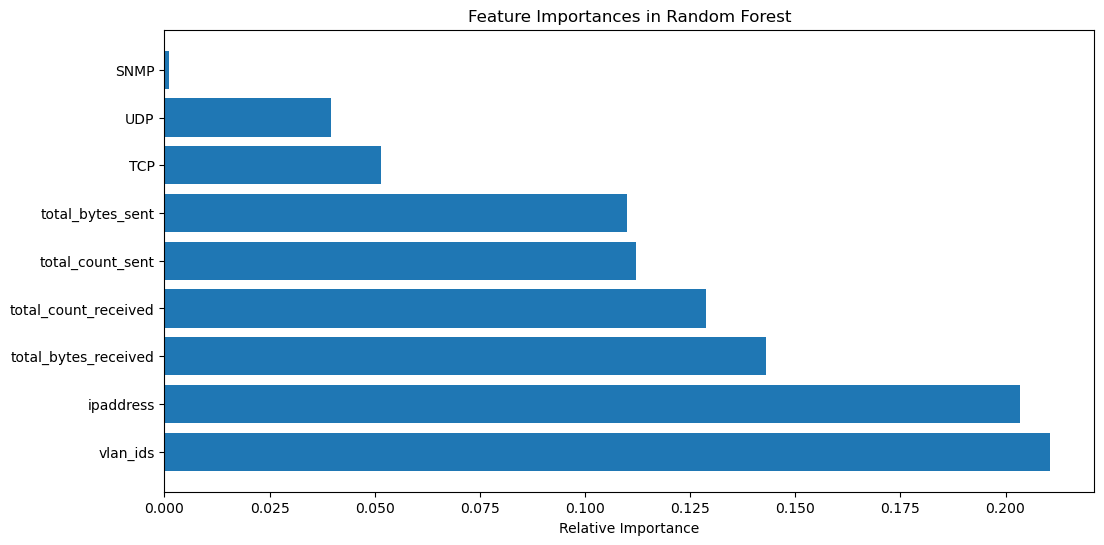

In [45]:
# Visualizing Feature Importance

importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1] 

plt.figure(figsize=(12, 6))
plt.title("Feature Importances in Random Forest")
plt.barh(range(X.shape[1]), importances[indices], align="center")
plt.yticks(range(X.shape[1]), np.array(X.columns)[indices])  
plt.xlabel("Relative Importance")
plt.show()


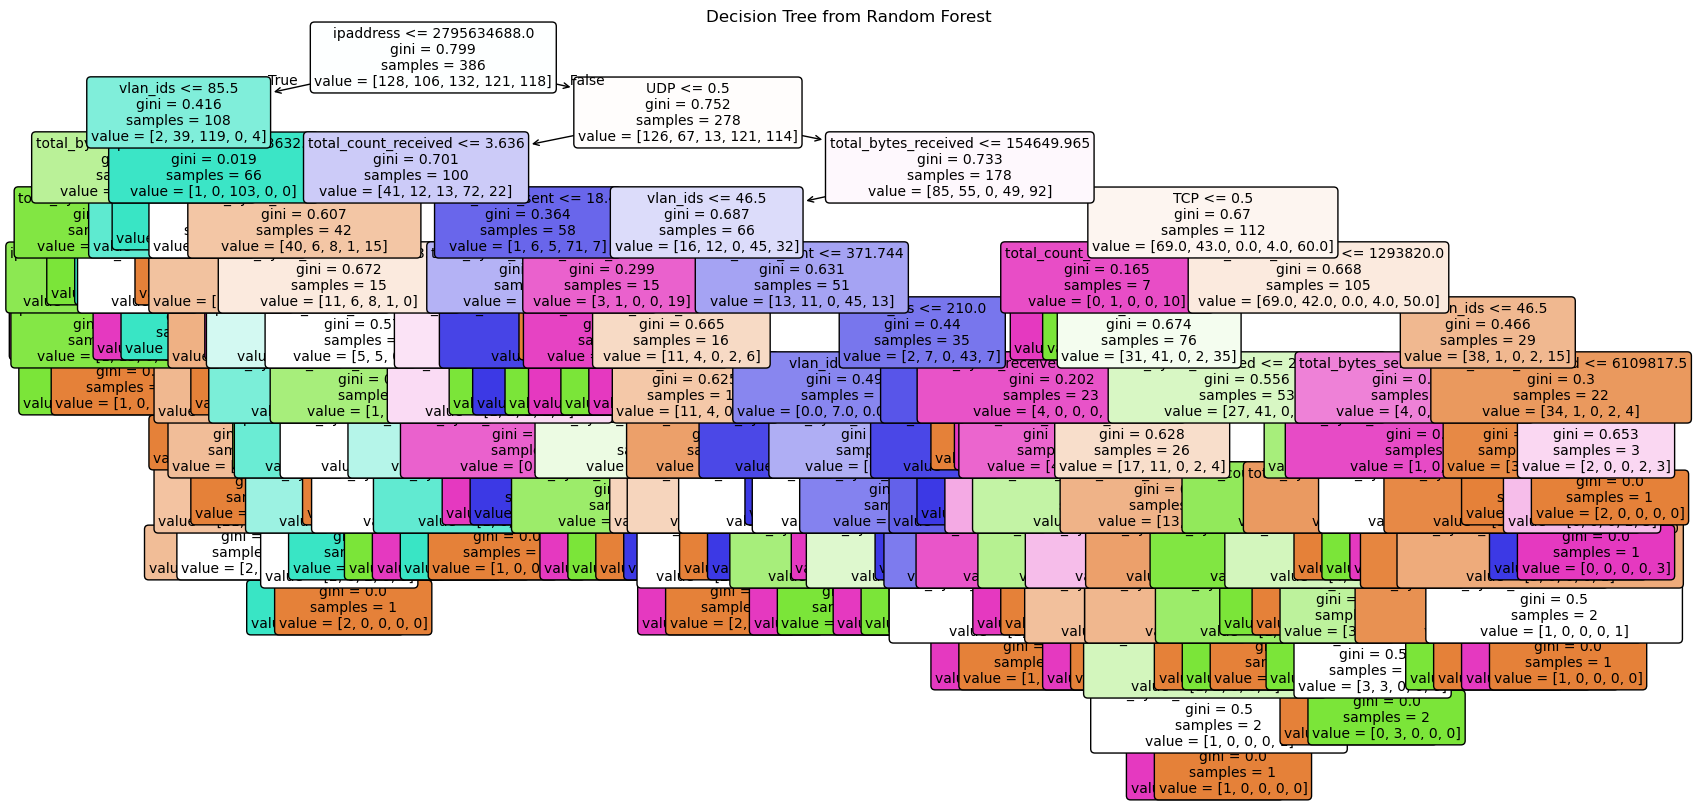

In [52]:
# Visualizing One Decision Tree from the Random Forest
tree_to_plot = rf_model.estimators_[0]  # The first tree from the forest
plt.figure(figsize=(20, 10))
plot_tree(tree_to_plot, feature_names=X.columns.tolist(), filled=True, rounded=True, fontsize=10)
plt.title("Decision Tree from Random Forest")
plt.show()


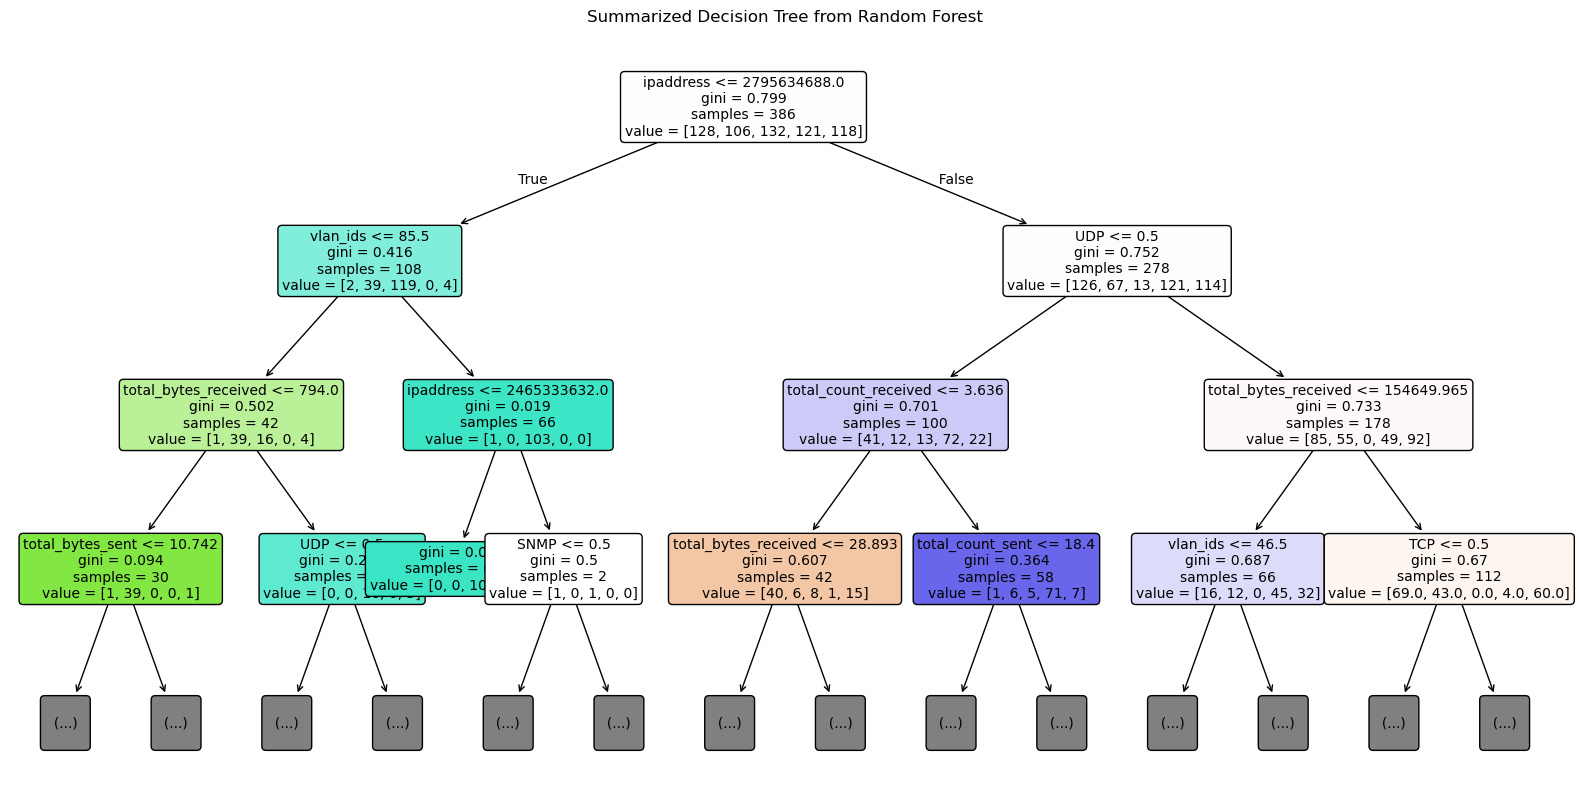

In [ ]:
# Visualizing One Decision Tree from the Random Forest

# Set max depth for the tree to limit its size
tree_to_plot = rf_model.estimators_[0]  # The first tree from the forest

plt.figure(figsize=(20, 10))
plot_tree(tree_to_plot, 
          feature_names=X.columns.tolist(), 
          filled=True, 
          rounded=True, 
          fontsize=10, 
          max_depth=3)  
plt.title("Summarized Decision Tree from Random Forest")
plt.show()
